# US Name

Transform china product quality table and by merging china_sigmas_hs3 and constructing kandhelwal_quality and others variables


# Description

- **Step:  Compute Kandhelwal quality**

## Variables

 
 

## Merge

china_sigmas_hs3

### Complementary information

**Reminder** 



# Target

- The file is saved in S3:
- bucket: datalake-datascience
- path: DATA/ECON/TRADE_DATA/CHINA/PRODUCT_QUALITY
- Glue data catalog should be updated
- database: chinese_trade
- Table prefix: china_
- table name: china_product_quality
- Analytics
- HTML: ANALYTICS/HTML_OUTPUT/china_product_quality
- Notebook: ANALYTICS/OUTPUT/china_product_quality

# Metadata

- Key: 179_VAT_rebate_quality
- Epic: Dataset transformation
- US: Quality estimate
- Task tag: #data-preparation
- Analytics reports: https://htmlpreview.github.io/?https://github.com/thomaspernet/VAT_rebate_quality_china/blob/master/00_data_catalog/HTML_ANALYSIS/CHINA_PRODUCT_QUALITY.html

# Input Cloud Storage

## Table/file

**Name**

- china_export_tariff_tax
- china_sigmas_hs3

**Github**

- https://github.com/thomaspernet/VAT_rebate_quality_china/blob/master/01_data_preprocessing/02_transform_tables/00_export_vat.md
- https://github.com/thomaspernet/VAT_rebate_quality_china/blob/master/01_data_preprocessing/00_download_data/SIGMA/sigma.py

# Destination Output/Delivery

## Table/file

**Name**

china_product_quality

**GitHub**

- https://github.com/thomaspernet/VAT_rebate_quality_china/blob/master/01_data_preprocessing/02_transform_tables/01_preparation_quality.md

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import os, shutil, json, re

path = os.getcwd()
parent_path = str(Path(path).parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-3'
bucket = 'datalake-datascience'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = True) 
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

## Load Sigma

In [4]:
db = 'chinese_trade'
table = 'china_sigmas_hs3'

In [5]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )
dtypes

{'ccode': 'string', 'cname': 'string', 'sigma': 'float', 'hs3': 'string'}

In [6]:
query = """
SELECT * 
FROM {0}.{1}
""".format(db, table)
sigma = (s3.run_query(
    query=query,
    database=db,
    s3_output='SQL_OUTPUT_ATHENA',
    filename='sigma',  # Add filename to print dataframe
    destination_key=None,  # Add destination key if need to copy output
    dtype = dtypes
)
        )
sigma.head()

,ccode,cname,sigma,hs3
0,62,China,108.186410,710
1,62,China,93.301980,530
2,62,China,39.281025,852
3,62,China,33.545135,850
4,62,China,32.270940,790


## Load trade data

In [7]:
table = 'china_export_tariff_tax'
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )
dtypes

{'geocode4_corr': 'string',
 'year': 'string',
 'regime': 'string',
 'hs6': 'string',
 'country_en': 'string',
 'iso_alpha': 'string',
 'quantity': 'float',
 'value': 'float',
 'unit_price': 'float',
 'lag_vat_m': 'float',
 'ln_lag_vat_m': 'float',
 'lag_vat_reb_m': 'float',
 'ln_lag_vat_reb_m': 'float',
 'lag_tax_rebate': 'float',
 'ln_lag_tax_rebate': 'float',
 'lag_import_tax': 'float',
 'ln_lag_import_tax': 'float',
 'cnt': 'float'}

In [8]:
query = """
SELECT * 
FROM {0}.{1}
""".format(db, table)
df_vat = s3.run_query(
    query=query,
    database="chinese_trade",
    s3_output="SQL_OUTPUT_ATHENA",
    filename="trade_vat",  # Add filename to print dataframe
    destination_key=None,  # Add destination key if need to copy output
    dtype=dtypes,
)

In [9]:
df_vat.head()

,geocode4_corr,year,regime,hs6,country_en,iso_alpha,quantity,value,unit_price,lag_vat_m,ln_lag_vat_m,lag_vat_reb_m,ln_lag_vat_reb_m,lag_tax_rebate,ln_lag_tax_rebate,lag_import_tax,ln_lag_import_tax,cnt
0,1101,2007,ELIGIBLE,843061,Pakistan,PAK,8.0,4900.0,612.50000,17.0,2.890372,17.0,2.890372,0.0,0.0,6.0,1.94591,1.0
1,1101,2007,ELIGIBLE,843061,Hong Kong,HKG,161.0,25872.0,160.69565,17.0,2.890372,17.0,2.890372,0.0,0.0,6.0,1.94591,1.0
2,1101,2008,ELIGIBLE,843061,Portugal,PRT,110.0,14366.0,130.60000,17.0,2.890372,17.0,2.890372,0.0,0.0,6.0,1.94591,1.0
3,1101,2009,NOT_ELIGIBLE,843061,Libya,LBY,74.0,470329.0,6355.79730,17.0,2.890372,17.0,2.890372,0.0,0.0,6.0,1.94591,1.0
4,1101,2010,NOT_ELIGIBLE,843061,Senegal,SEN,5.0,2970.0,594.00000,17.0,2.890372,17.0,2.890372,0.0,0.0,6.0,1.94591,1.0


# Steps
1. Merge Sigma
2. Create additional variables:
    - sigma_price = sigma * log(unit price)
    - y = log quantity + sigma_price
    - FE_ct = country year fixed effect
3. Compute the residual
4. Compute quality:
    - Adjusted: log(unit price) - residual
    - Kandhelwal : residual /(sigma - 1)
    
## Details

From [Fan et al. - Trade Liberalization, Quality, and Export Prices](https://paperpile.com/app/p/98954695-6715-0f43-ac54-55de0ba1cf20)

the majority of the trade literature in defining “quality” as unobserved attributes of a variety that make consumers willing to purchase relatively large quantities of the variety despite relatively high prices charged for the variety
we estimate the “effective quality” (quality as it enters consumer’s utility) of exported product $h$ shipped to destination country $c$ by firm $f$ in year $t$,$\left( q _ { f h c t } \right) ^ { \eta }$ via the empirical demand equation:

$$x _ { f h c t } = q _ { f h c t } ^ { \eta } p _ { f h c t } ^ { - \sigma } P _ { c t } ^ { \sigma - 1 } Y _ { c t }$$


Where $x _ { f h c t }$ denotes the demand for a particular firm $f$’s product

We take logs of the empirical demand equation, and then use the residual from the following OLS regression to infer quality: 

$$\ln \left( x _ { f h c t } \right) + \sigma \ln \left( p _ { f h c t } \right) = \varphi _ { h } + \varphi _ { c t } + \epsilon _ { f h c t }$$

where the country-year fixed effect $\varphi _ { c t }$ collects both the destination price index $P_{ct}$ and income $Y_{ct}$. The product fixed effect $\varphi _ { h }$ captures the difference in prices and qualitites across product categories due to the inherent characteristics of products.

Then estimated quality is $\ln \left( \hat { q } _ { f h c t } \right) = \hat { \epsilon } _ { f h c t }$

Consequently, quality-adjusted prices are the observed log prices less estimated effective quality:

$$\ln \left(\widetilde{p}_{f h c t}\right) = \ln \left( p _ { f h c t } \right) - \ln \left( \hat { q } _ { f h c t } \right)$$ 

From Khandewal 

$$\hat{\lambda}_{f c d t} \equiv \hat{\epsilon}_{f c h t} /(\sigma-1)$$

We also compute the following variables:

- $ \text{sigma_price} = \sigma \ln \left( \text{unit_price} \right)$ 
- $y = \ln Quantity + \text{sigma_price}$
- $\text{FE_ct} = \varphi _ { c t }$

In [10]:
df_quality = (
    df_vat.assign(
    hs2 = lambda x: x['hs6'].str[:2],
    hs3 = lambda x: x['hs6'].str[:3],
    hs4 = lambda x: x['hs6'].str[:4],
        
)
    .merge(sigma, how = 'inner')
    .assign(
        sigma_price = lambda x: x['sigma'].astype('float') * np.log(x['unit_price']),
        y = lambda x : np.log(x['quantity']) + x['sigma_price']
    )
)

Compute the Fixed Effect city-year, `FE_ct`

In [11]:
df_quality["FE_ct"] = pd.factorize(df_quality["year"].astype('string') + 
                                   df_quality["country_en"])[0]

### Step 3: compute the residual and quality

The formula is:

$$\ln \left( y _ { f h c t } \right)  = \varphi _ { h } + \varphi _ { c t } + \epsilon _ { f h c t }$$

There are two `quality`:

1. Price adjusted: $\ln \left( p _ { f h c t } \right) - \ln \left( \hat { q } _ { f h c t } \right)$
2. Khandelwal: $\hat{\epsilon}_{f c h t} /(\sigma-1)$

In [12]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

In [13]:
cat_proc = make_pipeline(
    OneHotEncoder()
)
preprocessor = make_column_transformer(
    (cat_proc, tuple(['hs6', 'FE_ct']))
)
clf = make_pipeline(preprocessor,
                    LinearRegression(fit_intercept=True, normalize=False))

It takes about 5/6m to compute the weights

In [14]:
%%time
MODEL = clf.fit(df_quality[['hs6', 'FE_ct']], df_quality['y']) 

CPU times: user 1min 9s, sys: 44 s, total: 1min 53s
Wall time: 1min 54s


In [15]:
df_quality = df_quality.assign(
    prediction = lambda x: MODEL.predict(x[['hs6', 'FE_ct']]),
    residual = lambda x: x['y'] - x['prediction'],
    price_adjusted_quality = lambda x: np.log(x['unit_price']) - x['residual'],
    kandhelwal_quality = lambda x: x['residual'] / (x['sigma'].astype('float') -1)
)  

In [16]:
cols_to_keep = [
    'ccode',
    'cname',
    'country_en',
    'iso_alpha',
    'geocode4_corr',
    'year',
    'regime',
    'hs6',
    'hs3',
    'hs4',
    'hs2',
    'quantity',
    'value',
    'unit_price',
    'sigma',
    'sigma_price',
    'y',
    'FE_ct',
    'prediction',
    'residual',
    'price_adjusted_quality',
    'kandhelwal_quality']
df_quality = df_quality.reindex(columns=cols_to_keep)
df_quality.head()

,ccode,cname,country_en,iso_alpha,geocode4_corr,year,regime,hs6,hs3,hs4,hs2,quantity,value,unit_price,sigma,sigma_price,y,FE_ct,prediction,residual,price_adjusted_quality,kandhelwal_quality
0,62,China,Pakistan,PAK,1101,2007,ELIGIBLE,843061,843,8430,84,8.0,4900.0,612.50000,2.768799,17.768905,19.848347,0,18.644793,1.203554,5.213995,0.680435
1,62,China,Hong Kong,HKG,1101,2007,ELIGIBLE,843061,843,8430,84,161.0,25872.0,160.69565,2.768799,14.064150,19.145554,1,16.468298,2.677256,2.402256,1.513601
2,62,China,Portugal,PRT,1101,2008,ELIGIBLE,843061,843,8430,84,110.0,14366.0,130.60000,2.768799,13.489976,18.190456,2,19.205696,-1.015240,5.887379,-0.573971
3,62,China,Libya,LBY,1101,2009,NOT_ELIGIBLE,843061,843,8430,84,74.0,470329.0,6355.79730,2.768799,24.246715,28.550780,3,19.335666,9.215114,-0.457992,5.209813
4,62,China,Senegal,SEN,1101,2010,NOT_ELIGIBLE,843061,843,8430,84,5.0,2970.0,594.00000,2.768799,17.683987,19.293425,4,19.217416,0.076009,6.310871,0.042972


Plot the average quality by year

![](https://drive.google.com/uc?export=view&id=1Q9KHBwEyx6tTuCU8hsy3_P46uIOm_dB9)

In [17]:
import matplotlib.pyplot as plt

<AxesSubplot:title={'center':'price_adjusted_quality'}, xlabel='year'>

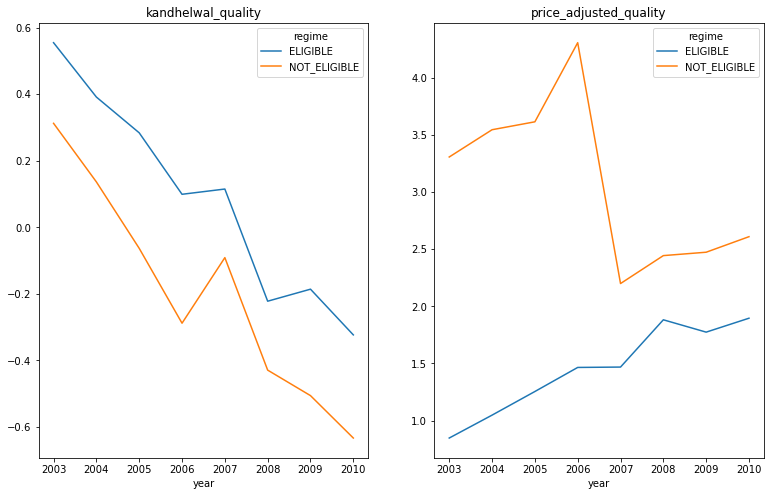

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13,8))
(
    df_quality
    .groupby(['year', 'regime'])['kandhelwal_quality']
    .mean()
    .unstack(-1)
    .plot
    .line(ax=axes[0], title = 'kandhelwal_quality')
)
(
    df_quality
    .groupby(['year', 'regime'])['price_adjusted_quality']
    .mean()
    .unstack(-1)
    .plot
    .line(ax=axes[1], title = 'price_adjusted_quality')
)

Save locally

In [19]:
input_path = os.path.join(parent_path,"00_data_catalog", "temporary_local_data",  "china_product_quality.csv")
df_quality.to_csv(input_path, index = False)

Save S3: `DATA/ECON/TRADE_DATA/CHINA/PRODUCT_QUALITY`

In [20]:
PATH_S3 = "DATA/ECON/TRADE_DATA/CHINA/PRODUCT_QUALITY"
s3.upload_file(input_path, PATH_S3)

# Table `china_product_quality`


First, we need to delete the table (if exist)

In [21]:
DatabaseName = 'chinese_trade'
table_name = 'china_product_quality'

In [22]:
try:
    response = glue.delete_table(
        database=DatabaseName,
        table=table_name
    )
    print(response)
except Exception as e:
    print(e)

{'ResponseMetadata': {'RequestId': 'e7e5e3b4-d8e0-4eb0-8da4-eaa9804bb918', 'HTTPStatusCode': 200, 'HTTPHeaders': {'date': 'Wed, 24 Mar 2021 06:46:41 GMT', 'content-type': 'application/x-amz-json-1.1', 'content-length': '2', 'connection': 'keep-alive', 'x-amzn-requestid': 'e7e5e3b4-d8e0-4eb0-8da4-eaa9804bb918'}, 'RetryAttempts': 0}}


# Validate query

This step is mandatory to validate the query in the ETL. If you are not sure about the quality of the query, go to the next step.

To validate the query, please fillin the json below. Don't forget to change the schema so that the crawler can use it.

1. Change the schema if needed. It is highly recommanded to add comment to the fields
2. Add a partition key:
    - Inform if there is group in the table so that, the parser can compute duplicate
3. Provide a description -> detail the steps 

1. Change the schema

Bear in mind that CSV SerDe (OpenCSVSerDe) does not support empty fields in columns defined as a numeric data type. All columns with missing values should be saved as string. 

In [23]:
s3_output = PATH_S3

In [24]:
for i in df_quality.columns:
    print({
        "Name": i,
        "Type": "",
        "Comment": ""
    })

{'Name': 'ccode', 'Type': '', 'Comment': ''}
{'Name': 'cname', 'Type': '', 'Comment': ''}
{'Name': 'country_en', 'Type': '', 'Comment': ''}
{'Name': 'iso_alpha', 'Type': '', 'Comment': ''}
{'Name': 'geocode4_corr', 'Type': '', 'Comment': ''}
{'Name': 'year', 'Type': '', 'Comment': ''}
{'Name': 'regime', 'Type': '', 'Comment': ''}
{'Name': 'hs6', 'Type': '', 'Comment': ''}
{'Name': 'hs3', 'Type': '', 'Comment': ''}
{'Name': 'hs4', 'Type': '', 'Comment': ''}
{'Name': 'hs2', 'Type': '', 'Comment': ''}
{'Name': 'quantity', 'Type': '', 'Comment': ''}
{'Name': 'value', 'Type': '', 'Comment': ''}
{'Name': 'unit_price', 'Type': '', 'Comment': ''}
{'Name': 'sigma', 'Type': '', 'Comment': ''}
{'Name': 'sigma_price', 'Type': '', 'Comment': ''}
{'Name': 'y', 'Type': '', 'Comment': ''}
{'Name': 'FE_ct', 'Type': '', 'Comment': ''}
{'Name': 'prediction', 'Type': '', 'Comment': ''}
{'Name': 'residual', 'Type': '', 'Comment': ''}
{'Name': 'price_adjusted_quality', 'Type': '', 'Comment': ''}
{'Name': 'k

In [25]:
schema = [
    {'Name': 'ccode', 'Type': 'string', 'Comment': 'country code'},
{'Name': 'cname', 'Type': 'string', 'Comment': 'country name'},
{'Name': 'country_en', 'Type': 'string', 'Comment': 'country name english'},
{'Name': 'iso_alpha', 'Type': 'string', 'Comment': ''},
{'Name': 'geocode4_corr', 'Type': 'string', 'Comment': 'city code'},
{'Name': 'year', 'Type': 'string', 'Comment': 'year'},
{'Name': 'regime', 'Type': 'string', 'Comment': 'eligible to vat rebate'},
{'Name': 'hs6', 'Type': 'string', 'Comment': 'HS6 6 digits'},
{'Name': 'hs3', 'Type': 'string', 'Comment': 'HS3 3 digits'},
{'Name': 'hs4', 'Type': 'string', 'Comment': 'HS4 4 digits'},
{'Name': 'hs2', 'Type': 'string', 'Comment': 'HS2 2 digits'},
{'Name': 'quantity', 'Type': 'float', 'Comment': 'Export quantity'},
{'Name': 'value', 'Type': 'float', 'Comment': 'Export value'},
{'Name': 'unit_price', 'Type': 'float', 'Comment': 'Export unit price'},
{'Name': 'sigma', 'Type': 'float', 'Comment': 'sigma'},
{'Name': 'sigma_price', 'Type': 'float', 'Comment': ''},
{'Name': 'y', 'Type': 'float', 'Comment': ''},
{'Name': 'FE_ct', 'Type': 'int', 'Comment': 'city year fixed effect'},
{'Name': 'prediction', 'Type': 'float', 'Comment': 'prediction OLS'},
{'Name': 'residual', 'Type': 'float', 'Comment': 'residual OLS'},
{'Name': 'price_adjusted_quality', 'Type': 'float', 'Comment': 'price adjusted'},
{'Name': 'kandhelwal_quality', 'Type': 'float', 'Comment': 'Kandhelwal quality'}
]

2. Provide a description

In [26]:
description = """
Compute Kandhelwal quality. The quality is computed at the city product-destination-level for each year in our sample
"""

3. provide metadata

- DatabaseName:
- TablePrefix:
- input: 
- filename: Name of the notebook or Python script: to indicate
- Task ID: from Coda
- index_final_table: a list to indicate if the current table is used to prepare the final table(s). If more than one, pass the index. Start at 0
- if_final: A boolean. Indicates if the current table is the final table -> the one the model will be used to be trained

In [27]:
name_json = 'parameters_ETL_VAT_rebate_quality_china.json'
path_json = os.path.join(str(Path(path).parent.parent), 'utils',name_json)

In [28]:
with open(path_json) as json_file:
    parameters = json.load(json_file)

In [29]:
partition_keys = ["geocode4_corr", "year", "regime","hs6", "country_en"]
notebookname =  "01_preparation_quality.ipynb"
index_final_table = [0]
if_final = 'False'

In [30]:
github_url = os.path.join(
    "https://github.com/",
    parameters['GLOBAL']['GITHUB']['owner'],
    parameters['GLOBAL']['GITHUB']['repo_name'],
    "blob/master",
    re.sub(parameters['GLOBAL']['GITHUB']['repo_name'],
           '', re.sub(
               r".*(?={})".format(parameters['GLOBAL']['GITHUB']['repo_name'])
               , '', path))[1:],
    re.sub('.ipynb','.md',notebookname)
)

Grab the input name from query: manually add input because data constructed with Python

In [31]:
list_input = ["", ""]
#tables = glue.get_tables(full_output = False)
#regex_matches = re.findall(r'(?=\.).*?(?=\s)|(?=\.\").*?(?=\")', query)
#for i in regex_matches:
#    cleaning = i.lstrip().rstrip().replace('.', '').replace('"', '')
#    if cleaning in tables and cleaning != table_name:
#        list_input.append(cleaning)

In [32]:
json_etl = {
    'description': description,
    'query': query,
    'schema': schema,
    'partition_keys': partition_keys,
    'metadata': {
        'DatabaseName': DatabaseName,
        'TableName': table_name,
        'input': list_input,
        'target_S3URI': os.path.join('s3://', bucket, s3_output),
        'from_athena': 'True',
        'filename': notebookname,
        'index_final_table' : index_final_table,
        'if_final': if_final,
         'github_url':github_url
    }
}
json_etl['metadata']

{'DatabaseName': 'chinese_trade',
 'TableName': 'china_product_quality',
 'input': ['', ''],
 'target_S3URI': 's3://datalake-datascience/DATA/ECON/TRADE_DATA/CHINA/PRODUCT_QUALITY',
 'from_athena': 'True',
 'filename': '01_preparation_quality.ipynb',
 'index_final_table': [0],
 'if_final': 'False',
 'github_url': 'https://github.com/thomaspernet/VAT_rebate_quality_china/blob/master/01_data_preprocessing/02_transform_tables/01_preparation_quality.md'}

**Chose carefully PREPARATION or TRANSFORMATION**

In [33]:
index_to_remove = next(
                (
                    index
                    for (index, d) in enumerate(parameters['TABLES']['TRANSFORMATION']['STEPS'])
                    if d['metadata']['TableName'] == table_name
                ),
                None,
            )
if index_to_remove != None:
    parameters['TABLES']['TRANSFORMATION']['STEPS'].pop(index_to_remove)
parameters['TABLES']['TRANSFORMATION']['STEPS'].append(json_etl)

In [34]:
print("Currently, the ETL has {} tables".format(len(parameters['TABLES']['TRANSFORMATION']['STEPS'])))

Currently, the ETL has 5 tables


Save JSON

In [35]:
with open(path_json, "w") as json_file:
    json.dump(parameters, json_file)

# Create or update the data catalog

The query is saved in the S3 (bucket `datalake-datascience`) but the table is not available yet in the Data Catalog. Use the function `create_table_glue` to generate the table and update the catalog.

Few parameters are required:

- name_crawler: Name of the crawler
- Role: Role to temporary provide an access tho the service
- DatabaseName: Name of the database to create the table
- TablePrefix: Prefix of the table. Full name of the table will be `TablePrefix` + folder name

To update the schema, please use the following structure

```
schema = [
    {
        "Name": "VAR1",
        "Type": "",
        "Comment": ""
    },
    {
        "Name": "VAR2",
        "Type": "",
        "Comment": ""
    }
]
```

In [36]:
TablePrefix = 'china_'
name_crawler = "crawl-industry-name"
Role = 'arn:aws:iam::468786073381:role/AWSGlueServiceRole-crawler-datalake'
target_S3URI = os.path.join("s3://datalake-datascience", PATH_S3)

In [37]:
glue.create_table_glue(
    target_S3URI,
    name_crawler,
    Role,
    DatabaseName,
    TablePrefix,
    from_athena=False,
    update_schema=schema,
)

An error occurred (EntityNotFoundException) when calling the DeleteTable operation: Table china_product_quality not found.


{'Name': 'china_product_quality',
 'DatabaseName': 'chinese_trade',
 'Owner': 'owner',
 'CreateTime': datetime.datetime(2021, 3, 24, 6, 47, 27, tzinfo=tzlocal()),
 'UpdateTime': datetime.datetime(2021, 3, 24, 6, 47, 32, tzinfo=tzlocal()),
 'LastAccessTime': datetime.datetime(2021, 3, 24, 6, 47, 27, tzinfo=tzlocal()),
 'Retention': 0,
 'StorageDescriptor': {'Columns': [{'Name': 'ccode',
    'Type': 'string',
    'Comment': 'country code'},
   {'Name': 'cname', 'Type': 'string', 'Comment': 'country name'},
   {'Name': 'country_en', 'Type': 'string', 'Comment': 'country name english'},
   {'Name': 'iso_alpha', 'Type': 'string', 'Comment': ''},
   {'Name': 'geocode4_corr', 'Type': 'string', 'Comment': 'city code'},
   {'Name': 'year', 'Type': 'string', 'Comment': 'year'},
   {'Name': 'regime', 'Type': 'string', 'Comment': 'eligible to vat rebate'},
   {'Name': 'hs6', 'Type': 'string', 'Comment': 'HS6 6 digits'},
   {'Name': 'hs3', 'Type': 'string', 'Comment': 'HS3 3 digits'},
   {'Name': '

In [38]:
s3_output_example = 'SQL_OUTPUT_ATHENA'

In [39]:
query_count = """
SELECT COUNT(*) AS CNT
FROM {}.{} 
""".format(DatabaseName, table_name)
output = s3.run_query(
                    query=query_count,
                    database=DatabaseName,
                    s3_output=s3_output_example,
    filename = 'count_{}'.format(table_name)
                )
output

,CNT
0,5746831


## Check Duplicates

One of the most important step when creating a table is to check if the table contains duplicates. The cell below checks if the table generated before is empty of duplicates. The code uses the JSON file to create the query parsed in Athena. 

You are required to define the group(s) that Athena will use to compute the duplicate. For instance, your table can be grouped by COL1 and COL2 (need to be string or varchar), then pass the list ['COL1', 'COL2'] 

In [40]:
#partition_keys = []

with open(path_json) as json_file:
    parameters = json.load(json_file)

In [41]:
### COUNT DUPLICATES
if len(partition_keys) > 0:
    groups = ' , '.join(partition_keys)

    query_duplicates = parameters["ANALYSIS"]['COUNT_DUPLICATES']['query'].format(
                                DatabaseName,table_name,groups
                                )
    dup = s3.run_query(
                                query=query_duplicates,
                                database=DatabaseName,
                                s3_output="SQL_OUTPUT_ATHENA",
                                filename="duplicates_{}".format(table_name))
    display(dup)


,CNT,CNT_DUPLICATE
0,1,5746831


## Count missing values

In [42]:
#table = 'XX'
schema = glue.get_table_information(
    database = DatabaseName,
    table = table_name
)['Table']

In [43]:
from datetime import date
today = date.today().strftime('%Y%M%d')

In [44]:
table_top = parameters["ANALYSIS"]["COUNT_MISSING"]["top"]
table_middle = ""
table_bottom = parameters["ANALYSIS"]["COUNT_MISSING"]["bottom"].format(
    DatabaseName, table_name
)

for key, value in enumerate(schema["StorageDescriptor"]["Columns"]):
    if key == len(schema["StorageDescriptor"]["Columns"]) - 1:

        table_middle += "{} ".format(
            parameters["ANALYSIS"]["COUNT_MISSING"]["middle"].format(value["Name"])
        )
    else:
        table_middle += "{} ,".format(
            parameters["ANALYSIS"]["COUNT_MISSING"]["middle"].format(value["Name"])
        )
query = table_top + table_middle + table_bottom
output = s3.run_query(
    query=query,
    database=DatabaseName,
    s3_output="SQL_OUTPUT_ATHENA",
    filename="count_missing",  ## Add filename to print dataframe
    destination_key=None,  ### Add destination key if need to copy output
)
display(
    output.T.rename(columns={0: "total_missing"})
    .assign(total_missing_pct=lambda x: x["total_missing"] / x.iloc[0, 0])
    .sort_values(by=["total_missing"], ascending=False)
    .style.format("{0:,.2%}", subset=["total_missing_pct"])
    .bar(subset="total_missing_pct", color=["#d65f5f"])
)

,total_missing,total_missing_pct
nb_obs,5746831,100.00%
quantity,0,0.00%
price_adjusted_quality,0,0.00%
residual,0,0.00%
prediction,0,0.00%
fe_ct,0,0.00%
y,0,0.00%
sigma_price,0,0.00%
sigma,0,0.00%
unit_price,0,0.00%


# Update Github Data catalog

The data catalog is available in Glue. Although, we might want to get a quick access to the tables in Github. In this part, we are generating a `README.md` in the folder `00_data_catalogue`. All tables used in the project will be added to the catalog. We use the ETL parameter file and the schema in Glue to create the README. 

Bear in mind the code will erase the previous README. 

In [45]:
README = """
# Data Catalogue

{}

    """

top_readme = """

## Table of Content

    """

template = """

## Table {0}

- Database: {1}
- S3uri: `{2}`
- Partitition: {3}
- Script: {5}

{4}

    """
github_link = os.path.join("https://github.com/", parameters['GLOBAL']['GITHUB']['owner'],
                           parameters['GLOBAL']['GITHUB']['repo_name'], "tree/master/00_data_catalog#table-")
for key, value in parameters['TABLES'].items():
    if key == 'CREATION':
        param = 'ALL_SCHEMA'
    else:
        param = 'STEPS'
        
    for schema in parameters['TABLES'][key][param]:
        description = schema['description']
        DatabaseName = schema['metadata']['DatabaseName']
        target_S3URI = schema['metadata']['target_S3URI']
        partition = schema['partition_keys']
        script = schema['metadata']['github_url']
        
        if param =='ALL_SCHEMA':
            table_name_git = '{}{}'.format(
                schema['metadata']['TablePrefix'],
                os.path.basename(schema['metadata']['target_S3URI']).lower()
            )
        else:
            try:
                table_name_git = schema['metadata']['TableName']
            except:
                table_name_git = '{}{}'.format(
                schema['metadata']['TablePrefix'],
                os.path.basename(schema['metadata']['target_S3URI']).lower()
            )
        
        tb = pd.json_normalize(schema['schema']).to_markdown()
        toc = "{}{}".format(github_link, table_name_git)
        top_readme += '\n- [{0}]({1})'.format(table_name_git, toc)

        README += template.format(table_name_git,
                                  DatabaseName,
                                  target_S3URI,
                                  partition,
                                  tb,
                                  script
                                  )
README = README.format(top_readme)
with open(os.path.join(str(Path(path).parent.parent), '00_data_catalog/README.md'), "w") as outfile:
    outfile.write(README)

# Analytics

In this part, we are providing basic summary statistic. Since we have created the tables, we can parse the schema in Glue and use our json file to automatically generates the analysis.

The cells below execute the job in the key `ANALYSIS`. You need to change the `primary_key` and `secondary_key` 

For a full analysis of the table, please use the following Lambda function. Be patient, it can takes between 5 to 30 minutes. Times varies according to the number of columns in your dataset.

Use the function as follow:

- `output_prefix`:  s3://datalake-datascience/ANALYTICS/OUTPUT/TABLE_NAME/
- `region`: region where the table is stored
- `bucket`: Name of the bucket
- `DatabaseName`: Name of the database
- `table_name`: Name of the table
- `group`: variables name to group to count the duplicates
- `primary_key`: Variable name to perform the grouping -> Only one variable for now
- `secondary_key`: Variable name to perform the secondary grouping -> Only one variable for now
- `proba`: Chi-square analysis probabilitity
- `y_var`: Continuous target variables

Check the job processing in Sagemaker: https://eu-west-3.console.aws.amazon.com/sagemaker/home?region=eu-west-3#/processing-jobs

The notebook is available: https://s3.console.aws.amazon.com/s3/buckets/datalake-datascience?region=eu-west-3&prefix=ANALYTICS/OUTPUT/&showversions=false

Please, download the notebook on your local machine, and convert it to HTML:

```
cd "/Users/thomas/Downloads/Notebook"
aws s3 cp s3://datalake-datascience/ANALYTICS/OUTPUT/asif_unzip_data_csv/Template_analysis_from_lambda-2020-11-22-08-12-20.ipynb .

## convert HTML no code
jupyter nbconvert --no-input --to html Template_analysis_from_lambda-2020-11-21-14-30-45.ipynb
jupyter nbconvert --to html Template_analysis_from_lambda-2020-11-22-08-12-20.ipynb
```

Then upload the HTML to: https://s3.console.aws.amazon.com/s3/buckets/datalake-datascience?region=eu-west-3&prefix=ANALYTICS/HTML_OUTPUT/

Add a new folder with the table name in upper case

In [ ]:
import boto3

key, secret_ = con.load_credential()
client_lambda = boto3.client(
    'lambda',
    aws_access_key_id=key,
    aws_secret_access_key=secret_,
    region_name = region)

In [ ]:
primary_key = ''
secondary_key = ''
y_var = ''

In [ ]:
payload = {
    "input_path": "s3://datalake-datascience/ANALYTICS/TEMPLATE_NOTEBOOKS/template_analysis_from_lambda.ipynb",
    "output_prefix": "s3://datalake-datascience/ANALYTICS/OUTPUT/{}/".format(table_name.upper()),
    "parameters": {
        "region": "{}".format(region),
        "bucket": "{}".format(bucket),
        "DatabaseName": "{}".format(DatabaseName),
        "table_name": "{}".format(table_name),
        "group": "{}".format(','.join(partition_keys)),
        "keys": "{},{}".format(primary_key,secondary_key),
        "y_var": "{}".format(y_var),
        "threshold":0
    },
}
payload

In [ ]:
response = client_lambda.invoke(
    FunctionName='RunNotebook',
    InvocationType='RequestResponse',
    LogType='Tail',
    Payload=json.dumps(payload),
)
response

# Generation report

In [46]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp
import sys
sys.path.append(os.path.join(parent_path, 'utils'))
import make_toc
import create_schema

In [47]:
def create_report(extension = "html", keep_code = False, notebookname = None):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            notebookname = notebookname  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [48]:
create_report(extension = "html", keep_code = True, notebookname =  notebookname)

Report Available at this adress:
 /home/ec2-user/VAT_rebate_quality_china/01_data_preprocessing/02_transform_tables/Reports/01_preparation_quality.html


In [49]:
create_schema.create_schema(path_json, path_save_image = os.path.join(parent_path, 'utils'))

In [50]:
### Update TOC in Github
for p in [parent_path,
          str(Path(path).parent),
          os.path.join(str(Path(path).parent), "00_download_data"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "00_statistical_exploration"),
          #os.path.join(str(Path(path).parent.parent), "02_data_analysis", "01_model_estimation"),
         ]:
    try:
        os.remove(os.path.join(p, 'README.md'))
    except:
        pass
    path_parameter = os.path.join(parent_path,'utils', name_json)
    md_lines =  make_toc.create_index(cwd = p, path_parameter = path_parameter)
    md_out_fn = os.path.join(p,'README.md')
    
    if p == parent_path:
    
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = True, path_parameter = path_parameter)
    else:
        make_toc.replace_index(md_out_fn, md_lines, Header = os.path.basename(p).replace('_', ' '), add_description = False)